## Crop Production Prediction

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, accuracy_score, confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor



Data = pd.read_csv(r"C:\Users\Sanika\Documents\AgroSmartAI\app\merged_agriculture_data.csv")
Data.columns

print(Data.info())

print(Data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69940 entries, 0 to 69939
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             69940 non-null  object 
 1   District          69940 non-null  object 
 2   Crop              69940 non-null  object 
 3   Year              69940 non-null  object 
 4   Season            69940 non-null  object 
 5   Area              69940 non-null  float64
 6   Area Units        69940 non-null  object 
 7   Production        69940 non-null  float64
 8   Production Units  69940 non-null  object 
 9   Yield             69940 non-null  float64
 10  Clean_District    69940 non-null  object 
 11  Clean_State       69940 non-null  object 
 12  Rain_Annual       69940 non-null  float64
 13  Rain_Jan_Feb      69940 non-null  float64
 14  Rain_Mar_May      69940 non-null  float64
 15  Rain_Jun_Sep      69940 non-null  float64
 16  Rain_Oct_Dec      69940 non-null  float6

In [2]:
Data.columns

Index(['State', 'District', 'Crop', 'Year', 'Season', 'Area', 'Area Units',
       'Production', 'Production Units', 'Yield', 'Clean_District',
       'Clean_State', 'Rain_Annual', 'Rain_Jan_Feb', 'Rain_Mar_May',
       'Rain_Jun_Sep', 'Rain_Oct_Dec', 'Temperature', 'Condition', 'Humidity',
       'Wind_Speed'],
      dtype='object')

In [3]:
Data['Area_Temp'] = Data['Area'] * Data['Temperature']
Data['Temp_Humidity'] = Data['Temperature'] * Data['Humidity']
Data['Humidity_Wind'] = Data['Humidity'] * Data['Wind_Speed']
Data['Temp_Wind'] = Data['Temperature'] * Data['Wind_Speed']
Data['Area_Humidity'] = Data['Area'] * Data['Humidity']
Data['Area_Temp_Wind'] = Data['Area'] * Data['Temperature'] * Data['Wind_Speed']
Data['Humidity_to_Temp'] = Data['Humidity'] / (Data['Temperature'] + 1e-5)
Data['Wind_to_Humidity'] = Data['Wind_Speed'] / (Data['Humidity'] + 1e-5)
Data['Temperature_Sq'] = Data['Temperature'] ** 2
Data['Humidity_Sq'] = Data['Humidity'] ** 2
Data['Wind_Speed_Sq'] = Data['Wind_Speed'] ** 2
Data['Rainfall_Per_Acre'] = Data['Rain_Annual'] / (Data['Area'] + 1e-5)
Data['Temp_Rainfall_Interaction'] = Data['Temperature'] * Data['Rain_Annual']
Data['Crop_Season'] = Data['Crop'].astype(str) + "_" + Data['Season'].astype(str)
Data['Crop_State'] = Data['Crop'].astype(str) + "_" + Data['State'].astype(str)


In [4]:
Data.columns

Index(['State', 'District', 'Crop', 'Year', 'Season', 'Area', 'Area Units',
       'Production', 'Production Units', 'Yield', 'Clean_District',
       'Clean_State', 'Rain_Annual', 'Rain_Jan_Feb', 'Rain_Mar_May',
       'Rain_Jun_Sep', 'Rain_Oct_Dec', 'Temperature', 'Condition', 'Humidity',
       'Wind_Speed', 'Area_Temp', 'Temp_Humidity', 'Humidity_Wind',
       'Temp_Wind', 'Area_Humidity', 'Area_Temp_Wind', 'Humidity_to_Temp',
       'Wind_to_Humidity', 'Temperature_Sq', 'Humidity_Sq', 'Wind_Speed_Sq',
       'Rainfall_Per_Acre', 'Temp_Rainfall_Interaction', 'Crop_Season',
       'Crop_State'],
      dtype='object')

In [5]:
Data.drop(columns=['District', 'Area Units', 'Production Units', 'Yield', 'Clean_District',
       'Clean_State', 'Rain_Jan_Feb', 'Rain_Mar_May', 'Rain_Jun_Sep', 'Rain_Oct_Dec', 'Condition'], inplace=True)

In [6]:
Data.columns

Index(['State', 'Crop', 'Year', 'Season', 'Area', 'Production', 'Rain_Annual',
       'Temperature', 'Humidity', 'Wind_Speed', 'Area_Temp', 'Temp_Humidity',
       'Humidity_Wind', 'Temp_Wind', 'Area_Humidity', 'Area_Temp_Wind',
       'Humidity_to_Temp', 'Wind_to_Humidity', 'Temperature_Sq', 'Humidity_Sq',
       'Wind_Speed_Sq', 'Rainfall_Per_Acre', 'Temp_Rainfall_Interaction',
       'Crop_Season', 'Crop_State'],
      dtype='object')

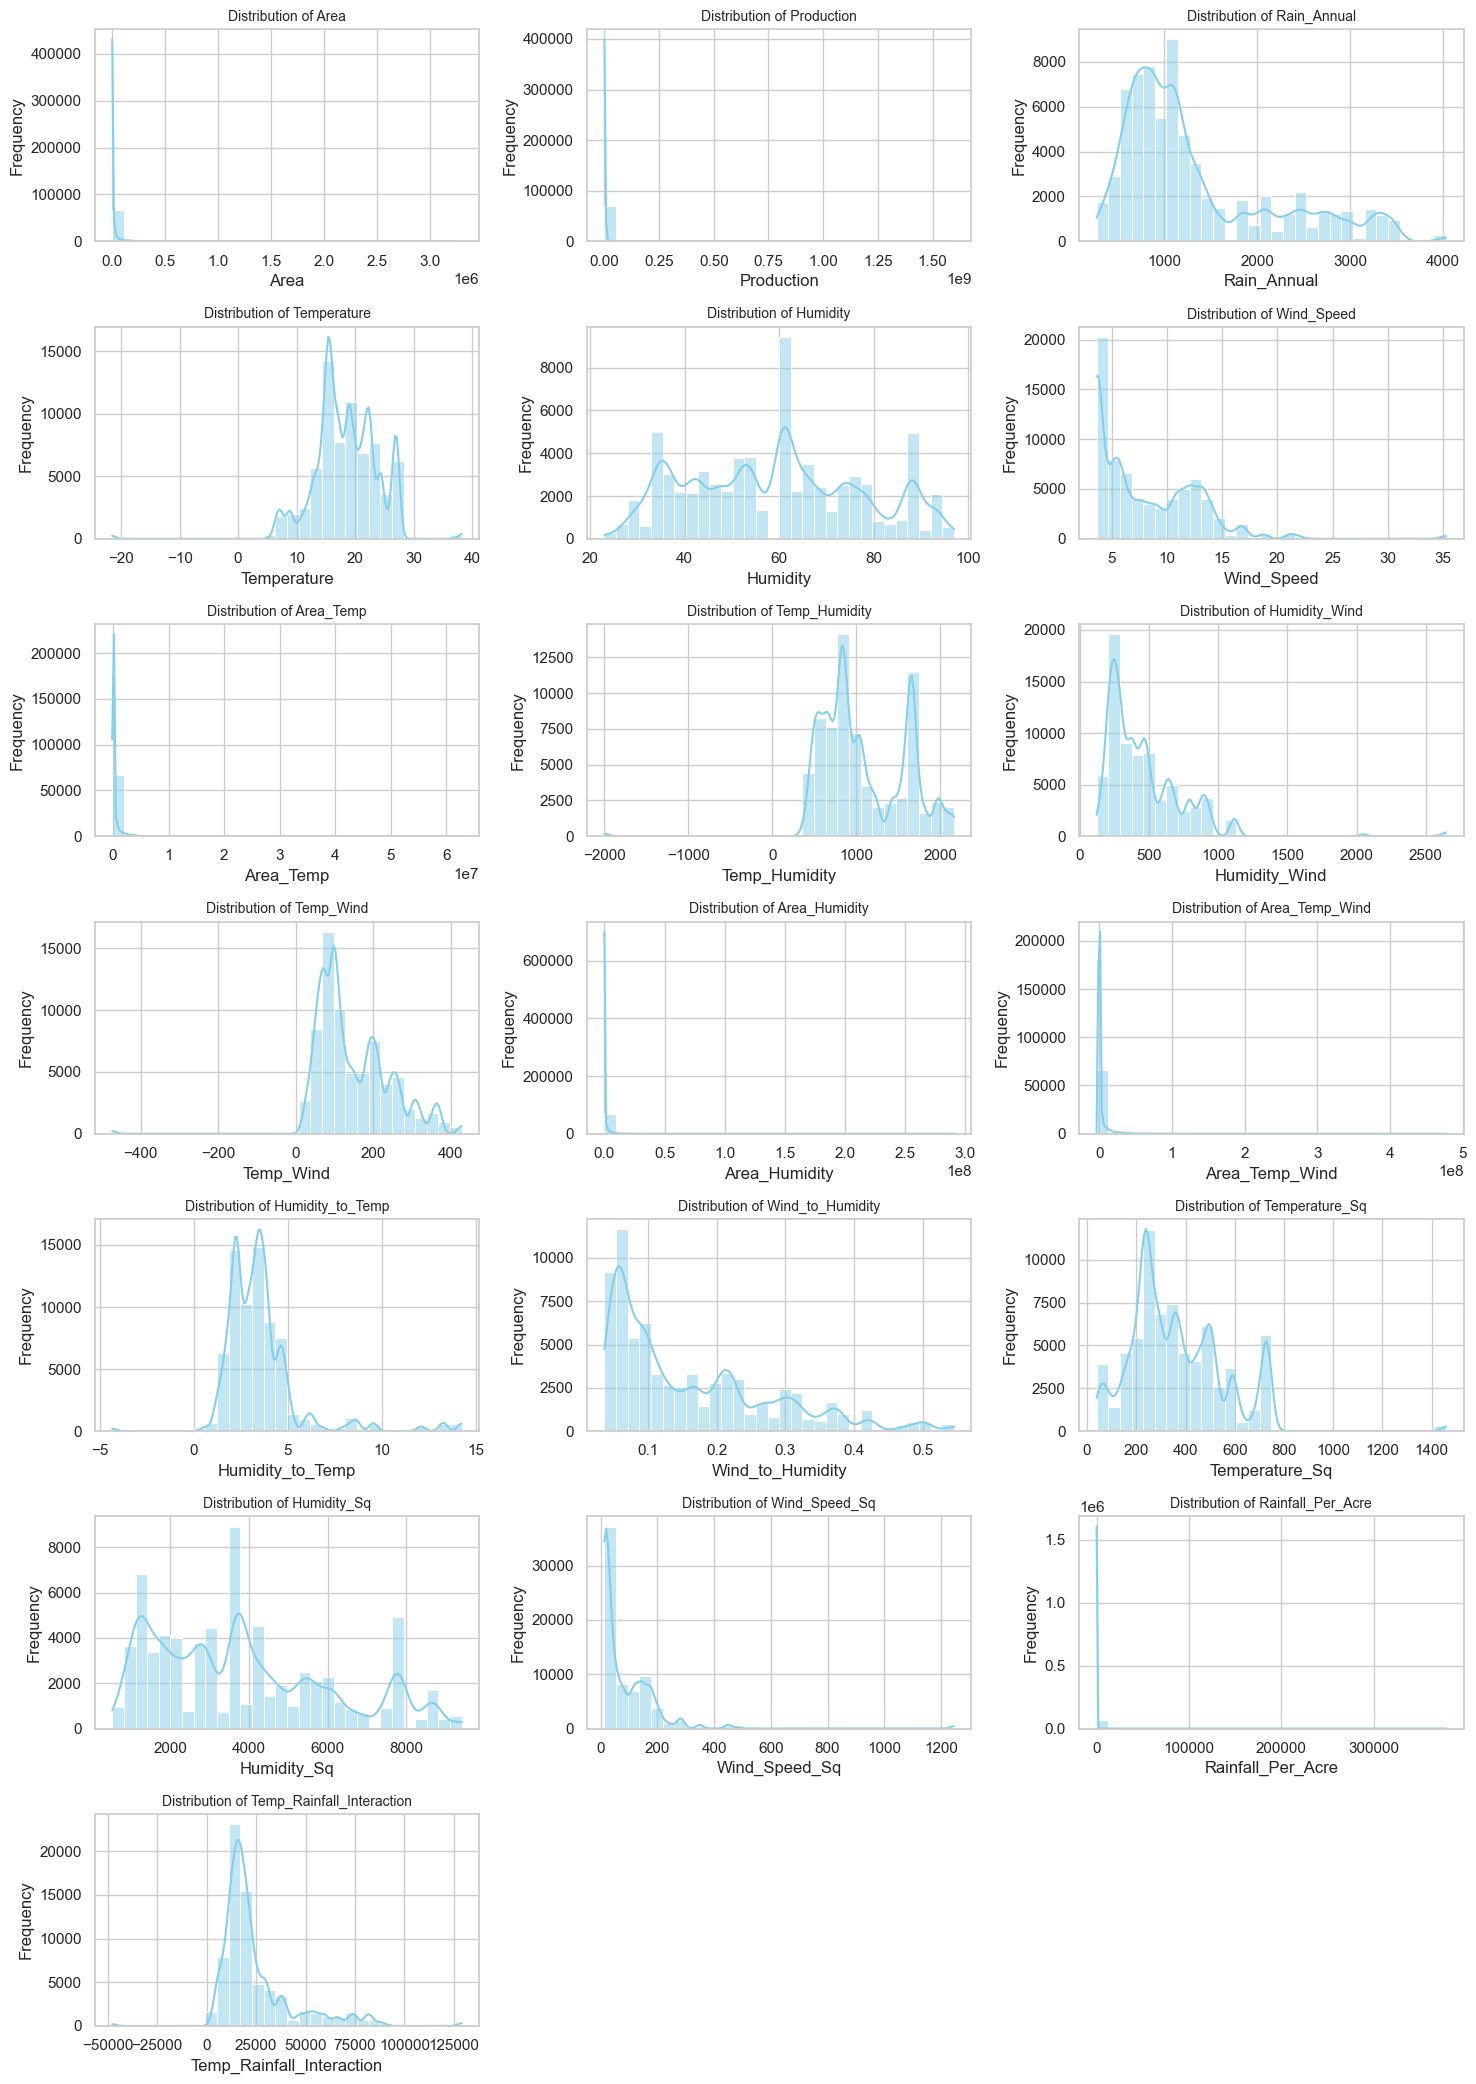

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numeric_cols = Data.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3  
n_rows = math.ceil(len(numeric_cols) / n_cols)

sns.set(style="whitegrid")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()  

for i, col in enumerate(numeric_cols):
    sns.histplot(Data[col], kde=True, bins=30, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [8]:
Data["Crop_State"]

0        Arecanut_ANDHRA PRADESH
1        Arecanut_ANDHRA PRADESH
2        Arecanut_ANDHRA PRADESH
3        Arecanut_ANDHRA PRADESH
4        Arecanut_ANDHRA PRADESH
                  ...           
69935          Wheat_WEST BENGAL
69936          Wheat_WEST BENGAL
69937          Wheat_WEST BENGAL
69938          Wheat_WEST BENGAL
69939          Wheat_WEST BENGAL
Name: Crop_State, Length: 69940, dtype: object

### Skewness wellbeing

In [9]:
Data['Log_Production'] = np.log1p(Data['Production'])
Data['Log_Area'] = np.log1p(Data['Area'])

### Label encoding

In [10]:
label_encoders = {}
for col in ['Crop_Season', 'Crop_State']:
    le = LabelEncoder()
    Data[col] = le.fit_transform(Data[col])
    label_encoders[col] = le

In [11]:
numeric_cols = [
    'Log_Area', 'Temperature', 'Humidity', 'Wind_Speed',
    'Area_Temp', 'Temp_Humidity', 'Humidity_Wind', 'Temp_Wind',
    'Area_Humidity', 'Area_Temp_Wind', 'Humidity_to_Temp',
    'Wind_to_Humidity', 'Temperature_Sq', 'Humidity_Sq',
    'Wind_Speed_Sq', 'Rainfall_Per_Acre', 'Temp_Rainfall_Interaction',
    'Crop_Season', 'Crop_State'
]

### Saving the order of features

In [12]:
#joblib.dump(numeric_cols, "numeric_feature_names.pkl")

In [13]:
X = Data[numeric_cols]
y = Data['Log_Production']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
X_train.columns


Index(['Log_Area', 'Temperature', 'Humidity', 'Wind_Speed', 'Area_Temp',
       'Temp_Humidity', 'Humidity_Wind', 'Temp_Wind', 'Area_Humidity',
       'Area_Temp_Wind', 'Humidity_to_Temp', 'Wind_to_Humidity',
       'Temperature_Sq', 'Humidity_Sq', 'Wind_Speed_Sq', 'Rainfall_Per_Acre',
       'Temp_Rainfall_Interaction', 'Crop_Season', 'Crop_State'],
      dtype='object')

### XGBMODEL

[0]	validation_0-rmse:3.05583
[100]	validation_0-rmse:0.57272
[200]	validation_0-rmse:0.54531
[300]	validation_0-rmse:0.54471
[375]	validation_0-rmse:0.54595

🔍 Training (Original Scale) Performance:
MAE : 263833.51
MSE : 41703886734298.02
RMSE: 6457854.65
R²  : 0.9621

🔍 Testing (Original Scale) Performance:
MAE : 391782.50
MSE : 101536108335125.27
RMSE: 10076512.71
R²  : 0.9319


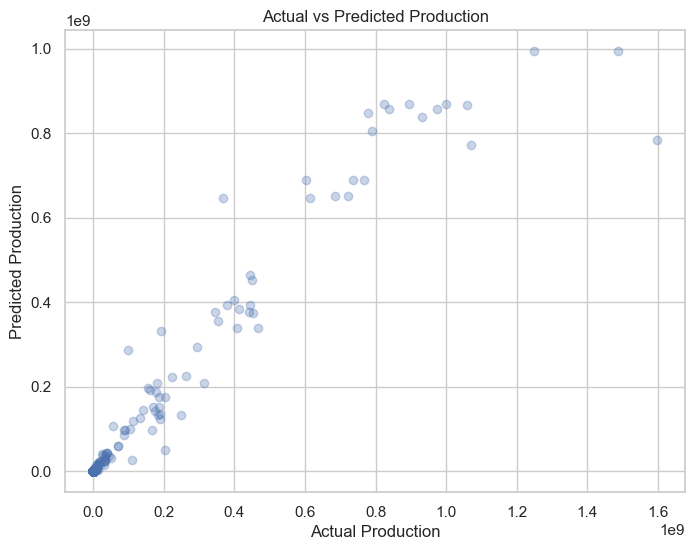

In [16]:
xgb_reg = XGBRegressor(
    learning_rate=0.05,
    n_estimators=2000,
    max_depth=12,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.5,
    reg_lambda=2,
    early_stopping_rounds=100,
    random_state=42,
    tree_method='hist',
    verbosity=1
)

xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# === Predictions ===
y_pred_train = np.expm1(xgb_reg.predict(X_train))
y_pred_test = np.expm1(xgb_reg.predict(X_test))
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)

# === Evaluation Function ===
def evaluate(y_true, y_pred, title):
    print(f"\n🔍 {title} Performance:")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE : {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²  : {r2_score(y_true, y_pred):.4f}")

# === Evaluate ===
evaluate(y_train_orig, y_pred_train, "Training (Original Scale)")
evaluate(y_test_orig, y_pred_test, "Testing (Original Scale)")

# === Visualize Actual vs Predicted ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_test, alpha=0.3)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Actual vs Predicted Production")
plt.grid(True)
plt.show()

In [17]:
#joblib.dump(xgb_reg, "xgb_production_model.pkl")

#joblib.dump(label_encoders, "label_encoders.pkl")

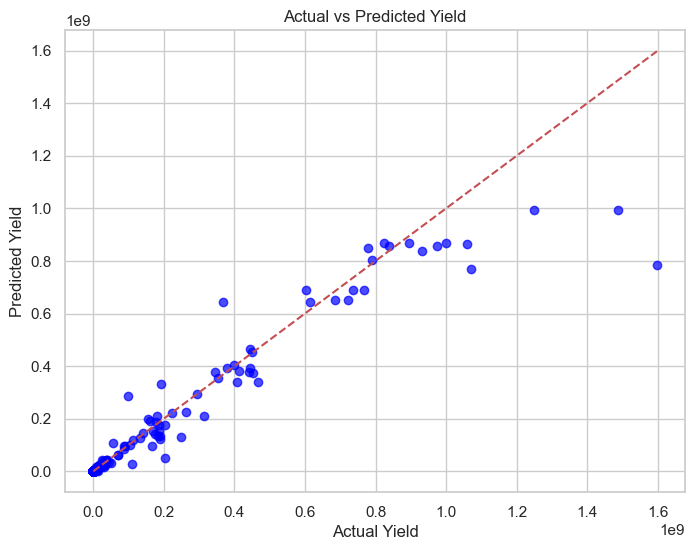

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_test, alpha=0.7, color='blue')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()],
         'r--')  # y=x line
plt.grid(True)
plt.show()

In [19]:
comparison_df = pd.DataFrame({
    'Actual_Yield': y_test_orig[:10].values,
    'Predicted_Yield': y_pred_test[:10]
})

print("\n First 10 Actual vs Predicted Yield Values:")
print(comparison_df)


 First 10 Actual vs Predicted Yield Values:
   Actual_Yield  Predicted_Yield
0          26.0        63.134544
1         189.0       283.915344
2          90.0        98.976883
3       53997.0     55122.570312
4           1.0         1.190564
5         230.0       157.303131
6          47.0        24.950127
7       43500.0     48125.605469
8         484.0       411.370453
9          70.0        91.653152


## Fertilizer Recommendation

In [20]:
df = pd.read_csv('fertilizer_recommendation_dataset.csv')
df.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Peaty Soil,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."


In [21]:
df.shape

(3100, 12)

In [22]:
df.isnull().sum()

Temperature    0
Moisture       0
Rainfall       0
PH             0
Nitrogen       0
Phosphorous    0
Potassium      0
Carbon         0
Soil           0
Crop           0
Fertilizer     0
Remark         0
dtype: int64

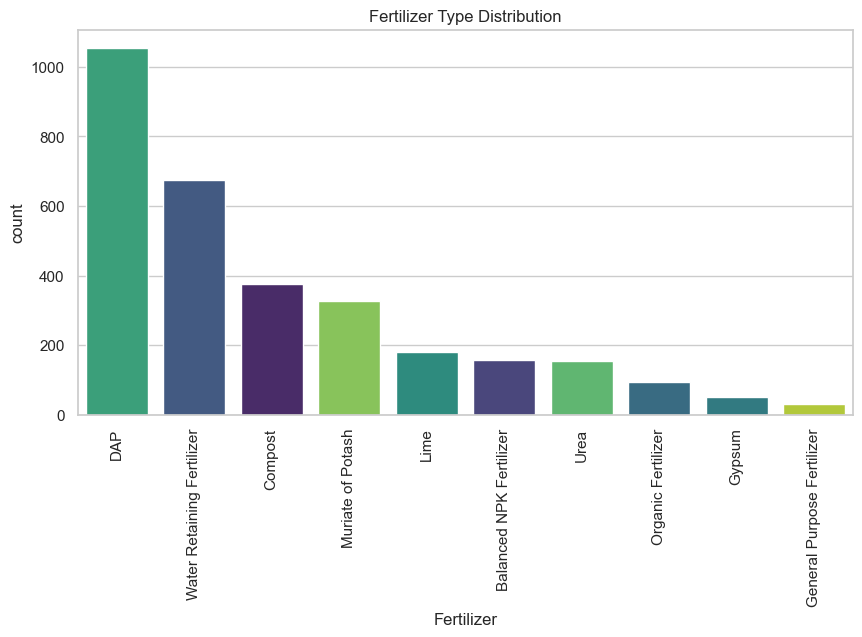

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x='Fertilizer', data=df, order=df['Fertilizer'].value_counts().index,hue='Fertilizer', palette='viridis')
plt.xticks(rotation=90)
plt.title('Fertilizer Type Distribution')
plt.show()

In [24]:
df['Fertilizer'].value_counts()

Fertilizer
DAP                           1054
Water Retaining Fertilizer     675
Compost                        375
Muriate of Potash              326
Lime                           181
Balanced NPK Fertilizer        157
Urea                           154
Organic Fertilizer              95
Gypsum                          52
General Purpose Fertilizer      31
Name: count, dtype: int64

In [25]:
df['Crop'].value_counts()

Crop
rice            100
wheat           100
Mung Bean       100
Tea             100
millet          100
maize           100
Lentil          100
Jute            100
Coffee          100
Cotton          100
Ground Nut      100
Peas            100
Rubber          100
Sugarcane       100
Tobacco         100
Kidney Beans    100
Moth Beans      100
Coconut         100
Black gram      100
Adzuki Beans    100
Pigeon Peas     100
Chickpea        100
banana          100
grapes          100
apple           100
mango           100
muskmelon       100
orange          100
papaya          100
pomegranate     100
watermelon      100
Name: count, dtype: int64

In [26]:
df['Soil'].value_counts()

Soil
Acidic Soil      1519
Peaty Soil        537
Neutral Soil      510
Loamy Soil        489
Alkaline Soil      45
Name: count, dtype: int64

In [27]:
df = pd.get_dummies(df, columns=['Soil'], dtype=np.float64)

In [28]:
df.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Remark,Soil_Acidic Soil,Soil_Alkaline Soil,Soil_Loamy Soil,Soil_Neutral Soil,Soil_Peaty Soil
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,rice,Compost,Enhances organic matter and improves soil stru...,0.0,0.0,1.0,0.0,0.0
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru...",0.0,0.0,1.0,0.0,0.0
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...,0.0,0.0,0.0,0.0,1.0
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru...",0.0,0.0,1.0,0.0,0.0
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ...",0.0,0.0,0.0,0.0,1.0


In [29]:
data = df.drop('Remark',axis=1)

In [30]:
data.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Soil_Acidic Soil,Soil_Alkaline Soil,Soil_Loamy Soil,Soil_Neutral Soil,Soil_Peaty Soil
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,rice,Compost,0.0,0.0,1.0,0.0,0.0
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,rice,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,rice,Water Retaining Fertilizer,0.0,0.0,0.0,0.0,1.0
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,rice,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,rice,Organic Fertilizer,0.0,0.0,0.0,0.0,1.0


In [31]:
soil_mapping = {
    'Soil_Acidic Soil': 'Acidic_Soil',
    'Soil_Alkaline Soil': 'Alkaline_Soil',
    'Soil_Loamy Soil': 'Loamy_Soil',
    'Soil_Neutral Soil': 'Neutral_Soil',
    'Soil_Peaty Soil': 'Peaty_Soil'
}

In [32]:
data.rename(columns=soil_mapping,inplace=True)

In [33]:
data.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Acidic_Soil,Alkaline_Soil,Loamy_Soil,Neutral_Soil,Peaty_Soil
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,rice,Compost,0.0,0.0,1.0,0.0,0.0
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,rice,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,rice,Water Retaining Fertilizer,0.0,0.0,0.0,0.0,1.0
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,rice,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,rice,Organic Fertilizer,0.0,0.0,0.0,0.0,1.0


In [34]:
label_encoder = LabelEncoder()
data['Crops'] = label_encoder.fit_transform(data['Crop'])

In [35]:
data.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Acidic_Soil,Alkaline_Soil,Loamy_Soil,Neutral_Soil,Peaty_Soil,Crops
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,rice,Compost,0.0,0.0,1.0,0.0,0.0,28
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,rice,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0,28
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,rice,Water Retaining Fertilizer,0.0,0.0,0.0,0.0,1.0,28
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,rice,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0,28
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,rice,Organic Fertilizer,0.0,0.0,0.0,0.0,1.0,28


In [36]:
data = data.drop('Crop',axis=1)

### EDA

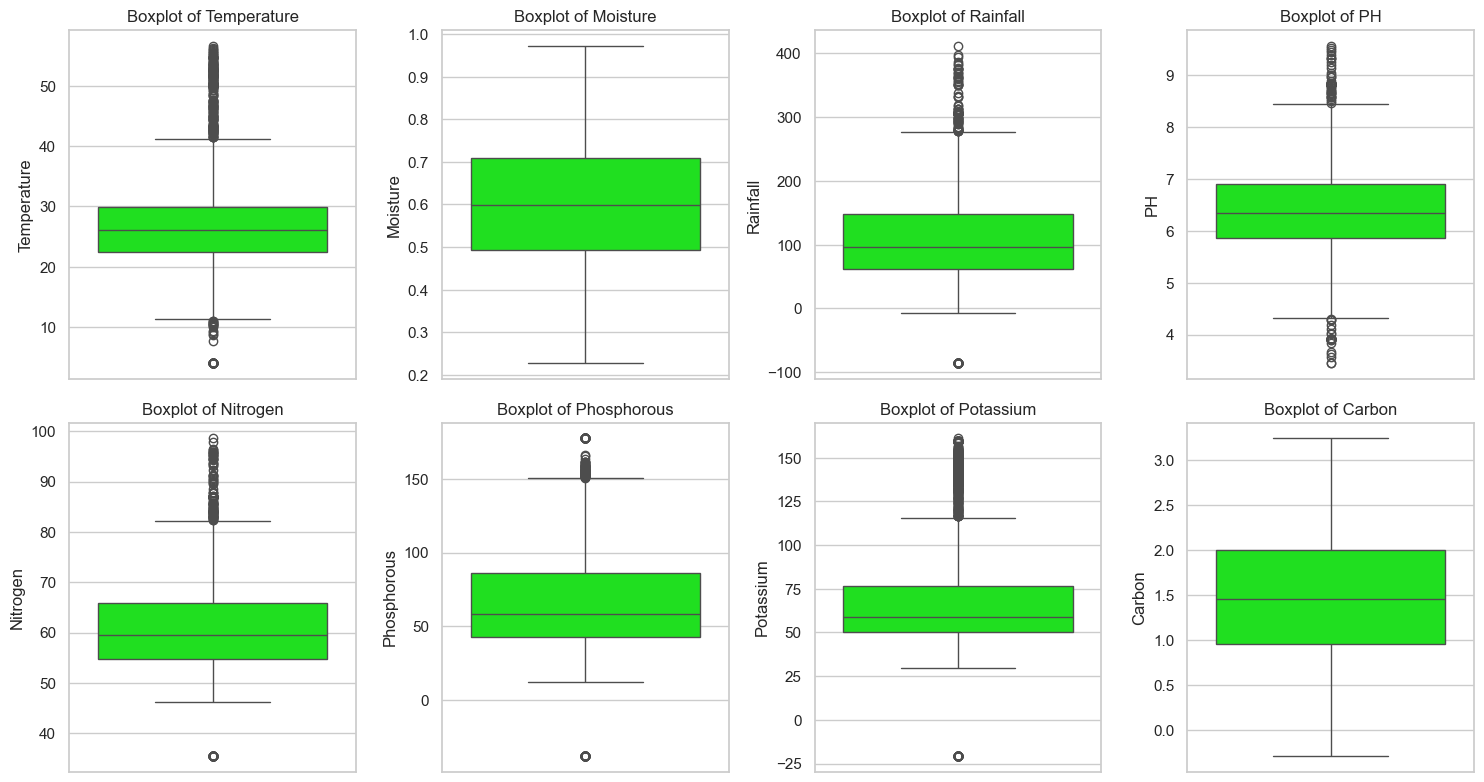

In [37]:
# Boxplots to detect outliers
plt.figure(figsize=(15,8))
for i, col in enumerate(['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon']):
    plt.subplot(2,4,i+1)
    sns.boxplot(y=data[col],color='lime')
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')
    plt.ylabel(col)

plt.tight_layout()
plt.show() 

In [38]:
# Handle Outliers
# IQR Method to identify and cap Outliers
def cap_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)


for col in ['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon']:
    cap_outliers(data, col)

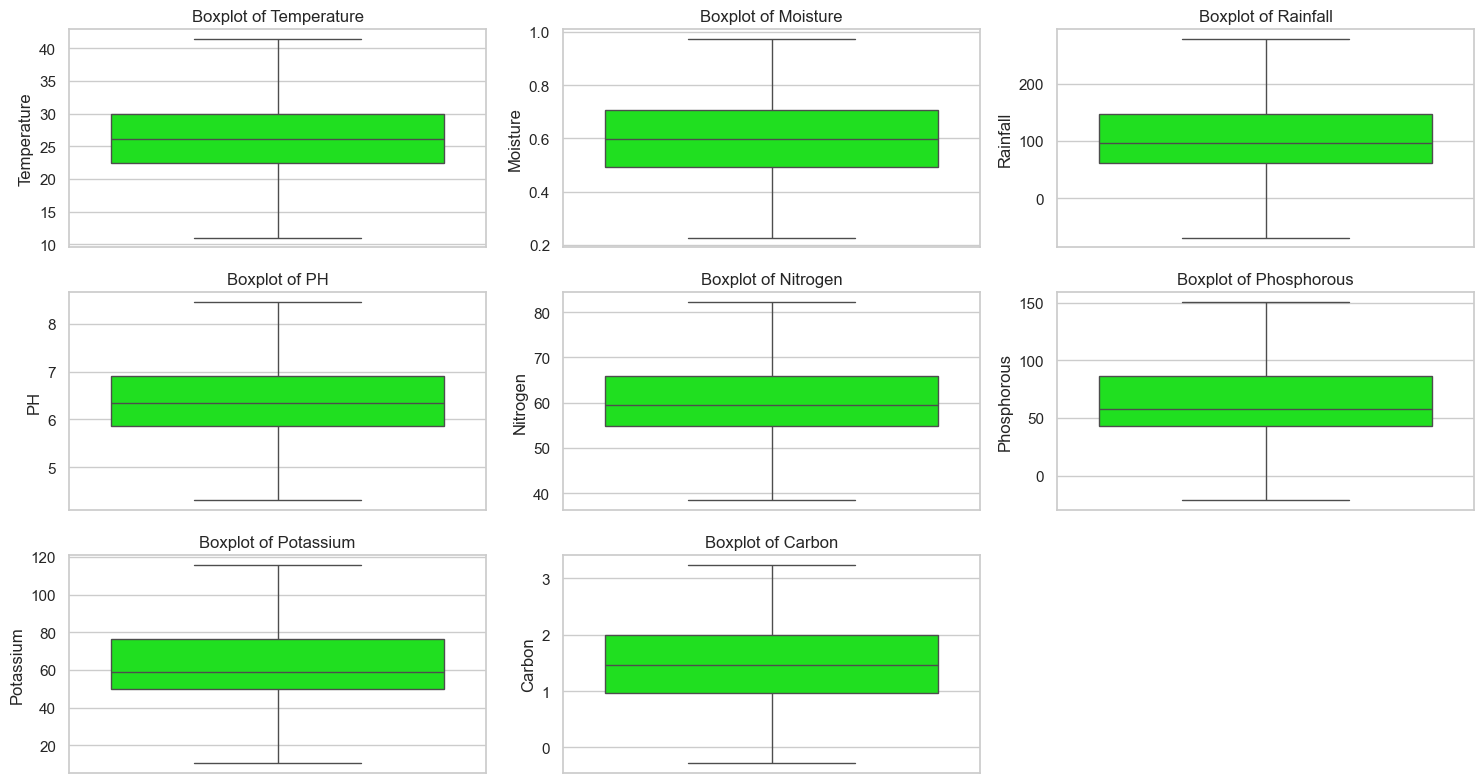

In [39]:
plt.figure(figsize=(15,8))
for i, col in enumerate(['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon']):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=data[col],color='lime')
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

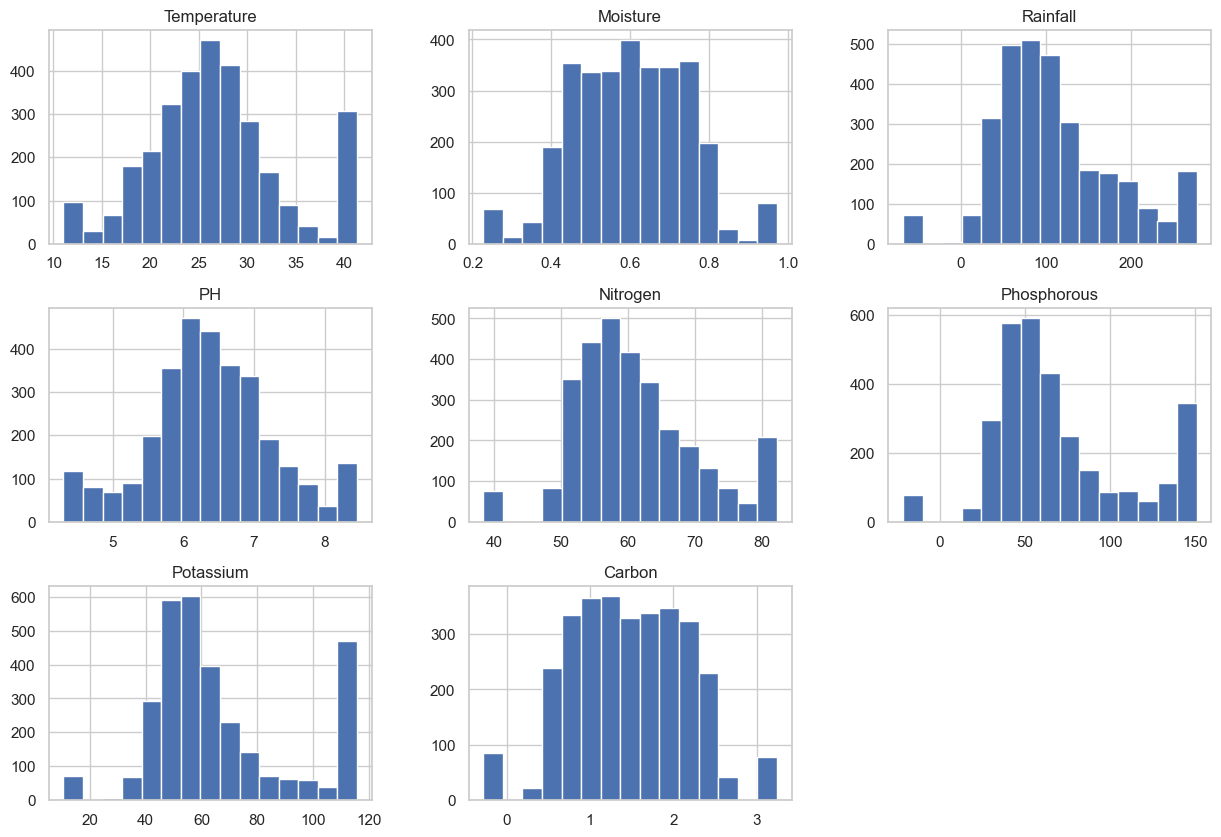

In [40]:
# Histograms for the numerical cols
data[['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon']].hist(bins=15, figsize=(15, 10))
plt.show()

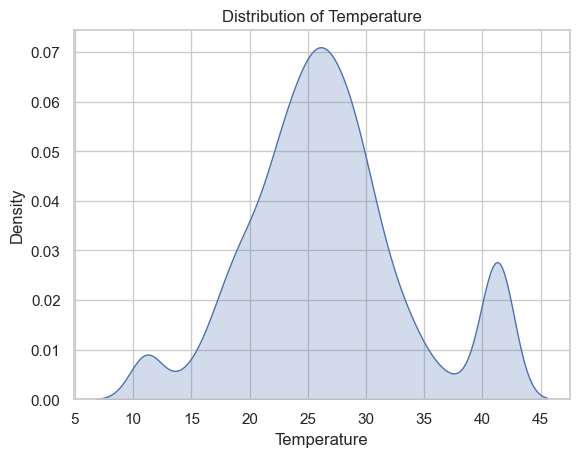

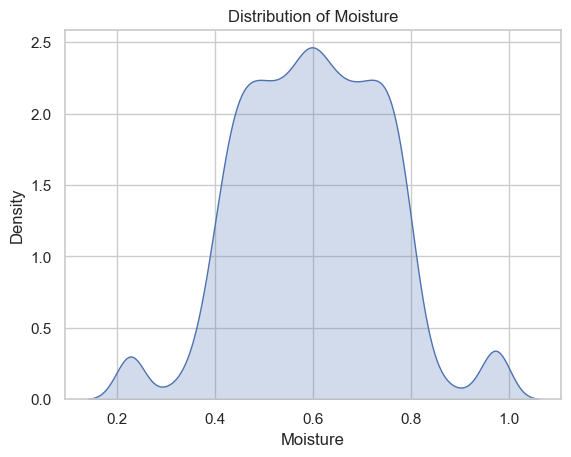

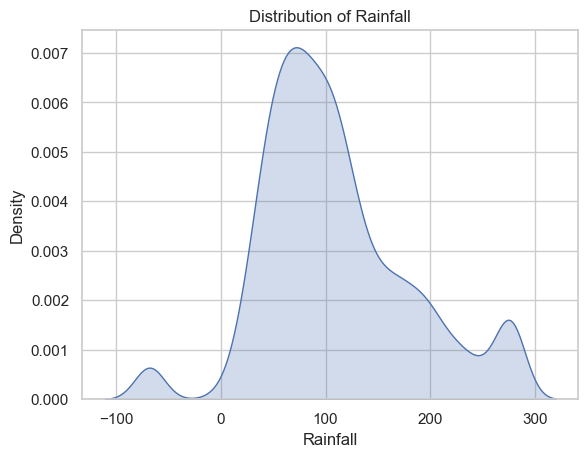

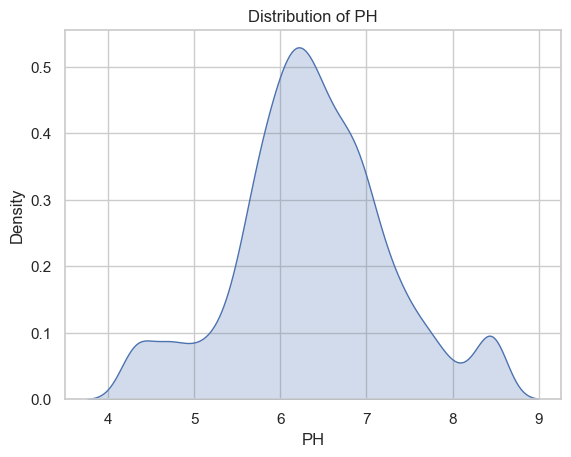

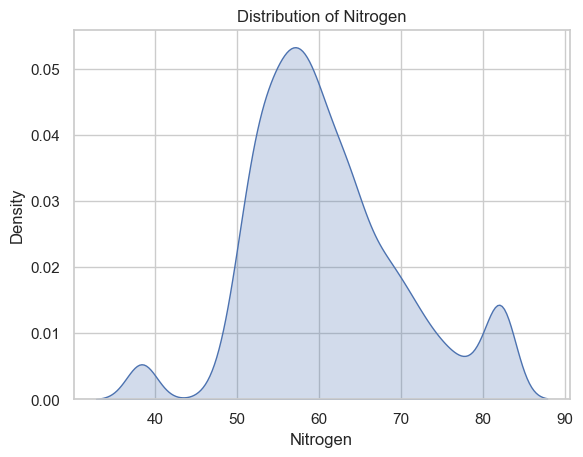

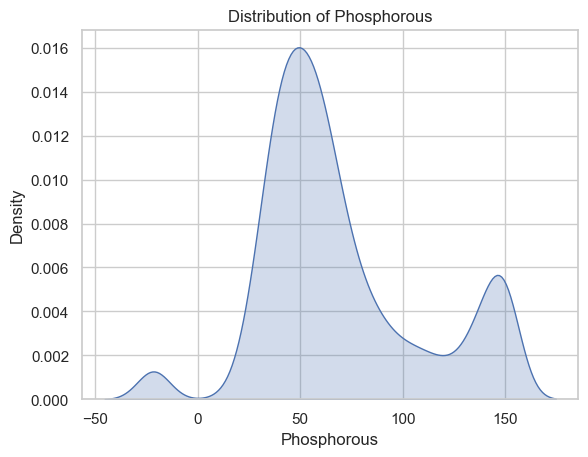

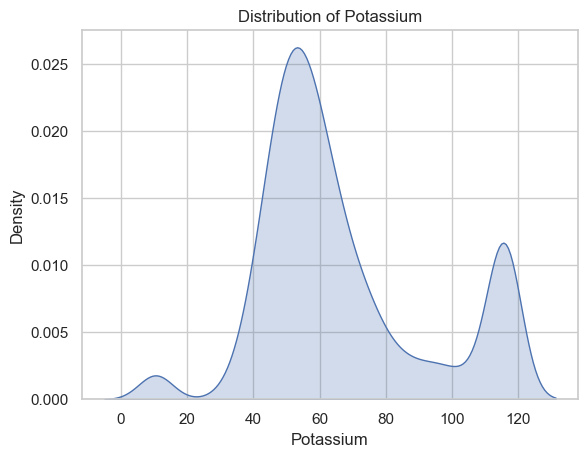

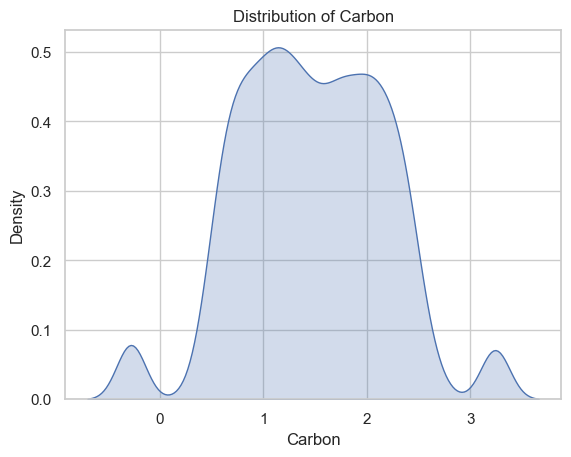

In [41]:
# KDE plots for numerical features
for col in['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon']:
    sns.kdeplot(data[col], fill=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [42]:
label_encoder_fertilizer = LabelEncoder()
data['fertilizer'] = label_encoder_fertilizer.fit_transform(data['Fertilizer'])

In [43]:
data.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Fertilizer,Acidic_Soil,Alkaline_Soil,Loamy_Soil,Neutral_Soil,Peaty_Soil,Crops,fertilizer
0,41.356961,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Compost,0.0,0.0,1.0,0.0,0.0,28,1
1,21.633318,0.721958,277.122525,7.173131,71.583316,150.713567,115.807958,1.234242,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0,28,0
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Water Retaining Fertilizer,0.0,0.0,0.0,0.0,1.0,28,9
3,26.241975,0.755095,212.703513,6.883367,78.033687,150.713567,115.807958,1.517556,Balanced NPK Fertilizer,0.0,0.0,1.0,0.0,0.0,28,0
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Organic Fertilizer,0.0,0.0,0.0,0.0,1.0,28,7


In [44]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon','Acidic_Soil','Alkaline_Soil','Loamy_Soil','Neutral_Soil','Peaty_Soil','Crops']])
X = pd.DataFrame(scaled_features, columns=['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon','Acidic_Soil','Alkaline_Soil','Loamy_Soil','Neutral_Soil','Peaty_Soil','Crops'])
y = data['fertilizer']

In [45]:
feature_names = X.columns.tolist()

In [46]:
data.shape

(3100, 16)

In [47]:
X.shape

(3100, 14)

In [48]:
y.shape

(3100,)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train.columns

Index(['Temperature', 'Moisture', 'Rainfall', 'PH', 'Nitrogen', 'Phosphorous',
       'Potassium', 'Carbon', 'Acidic_Soil', 'Alkaline_Soil', 'Loamy_Soil',
       'Neutral_Soil', 'Peaty_Soil', 'Crops'],
      dtype='object')

### Random Forest Classifier

In [51]:
model = RandomForestClassifier(random_state=42,n_estimators=200)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [52]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


In [53]:
model.score(X_test,y_test)

0.9854838709677419

In [54]:
cm = confusion_matrix(y_test,y_pred)

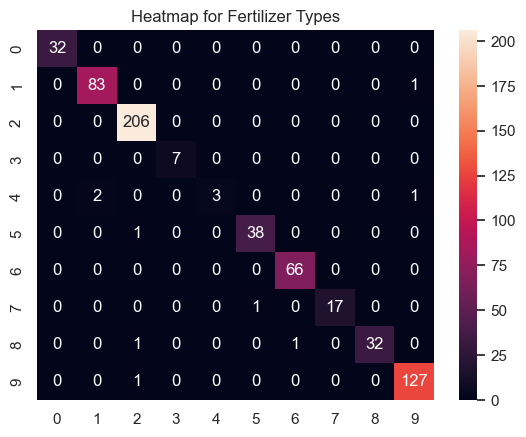

In [55]:
sns.heatmap(cm,annot=True,fmt='d')
plt.title("Heatmap for Fertilizer Types")
plt.show()

### Classification Report

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.98      0.99      0.98        84
           2       0.99      1.00      0.99       206
           3       1.00      1.00      1.00         7
           4       1.00      0.50      0.67         6
           5       0.97      0.97      0.97        39
           6       0.99      1.00      0.99        66
           7       1.00      0.94      0.97        18
           8       1.00      0.94      0.97        34
           9       0.98      0.99      0.99       128

    accuracy                           0.99       620
   macro avg       0.99      0.93      0.95       620
weighted avg       0.99      0.99      0.98       620



In [57]:
from sklearn.preprocessing import LabelEncoder

y_pred = model.predict(X_test) 

fertilizer_names = label_encoder_fertilizer.inverse_transform(y_pred.astype(int))

actual_names = label_encoder_fertilizer.inverse_transform(y_test.astype(int))

import pandas as pd
comparison_df = pd.DataFrame({
    "Actual_Fertilizer": actual_names[:10],
    "Predicted_Fertilizer": fertilizer_names[:10]
})

print("\n First 10 Actual vs Predicted Fertilizers:")
print(comparison_df)



 First 10 Actual vs Predicted Fertilizers:
            Actual_Fertilizer        Predicted_Fertilizer
0  Water Retaining Fertilizer  Water Retaining Fertilizer
1           Muriate of Potash           Muriate of Potash
2                     Compost                     Compost
3           Muriate of Potash           Muriate of Potash
4                         DAP                         DAP
5                         DAP                         DAP
6                         DAP                         DAP
7                         DAP                         DAP
8                         DAP                         DAP
9                     Compost                     Compost


In [58]:
#dump(model, "fertilizer_recommendation.joblib")
#dump(scaler, "fertilizer_scaler.joblib")
#dump(label_encoder_fertilizer, "fertilizer_encoder.joblib")
#dump(label_encoder, "crop_encoder.joblib")
#dump(feature_names, "fertilizer_feature_names.joblib")